# Named Entity Recognition with Python

## Preprocessing 

In [1]:
import tensorflow as tf
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
data = pd.read_csv('ner_dataset.csv')
data.head(5)

,Unnamed: 0,Sentence #,Word,POS,Tag
0,0,Sentence: 1,Thousands,NNS,O
1,1,NaN,of,IN,O
2,2,NaN,demonstrators,NNS,O
3,3,NaN,have,VBP,O
4,4,NaN,marched,VBN,O


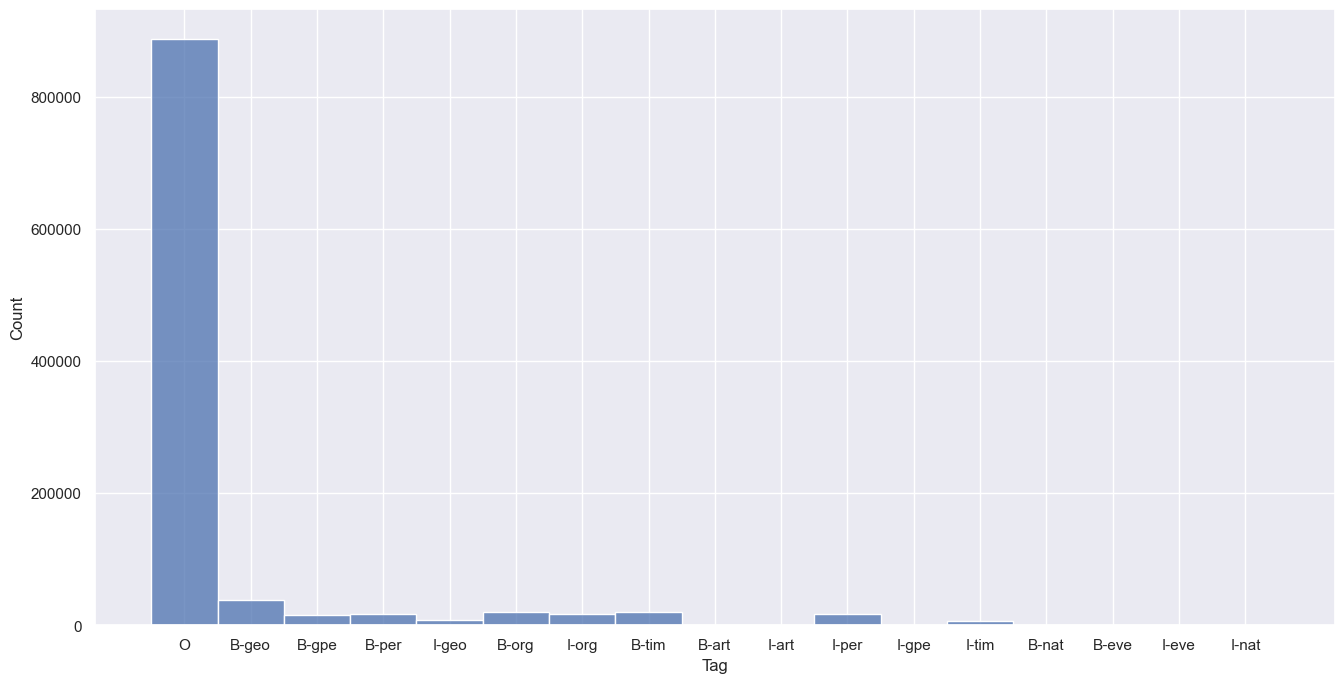

In [2]:
import matplotlib.pyplot as plt
import  seaborn as sns

plt.figure(figsize=(16, 8))
sns.set()
sns.histplot(data.Tag)
plt.show()

In [40]:
from itertools import chain
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    if token_or_tag == 'token':
        vocab = list(set(data.Word.to_list()))
    else:
        vocab = list(set(data.Tag.to_list()))
    idx2tok = {idx:tok for idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok

token2idx, idx2token = get_dict_map(data, 'token')
tag2idx, idx2tag = get_dict_map(data, 'tag')


In [4]:
data['Word_idx'] = data.Word.map(token2idx)
data['Tag_idx'] = data.Tag.map(tag2idx)
data_fillna = data.fillna(method='ffill', axis=0)
data_group = data_fillna.groupby(
    ['Sentence #'], as_index=False
)['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))

In [5]:
data.head(5)

,Unnamed: 0,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,0,Sentence: 1,Thousands,NNS,O,27893,8
1,1,NaN,of,IN,O,23700,8
2,2,NaN,demonstrators,NNS,O,6498,8
3,3,NaN,have,VBP,O,31836,8
4,4,NaN,marched,VBN,O,25034,8


In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [7]:
def get_pad_train_test_val(data_group, data):
    n_tag = len(list(set(data.Word.to_list())))
    n_tokens = len(list(set(data.Tag.to_list())))

    tokens = data_group['Word_idx'].to_list()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value=n_tokens-1)
    tags = data_group['Tag_idx'].to_list()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value=tag2idx['O'])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    _tokens, test_tokens, _tags, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=420)
    train_tokens, val_tokens, train_tags, val_tags = train_test_split(_tokens, _tags, test_size=0.2, train_size=0.8, random_state=420) 
    return train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags                


In [8]:
train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = get_pad_train_test_val(data_group, data)

In [9]:
print(
        'train_tokens length:', len(train_tokens),
        '\ntrain_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntest_tags:', len(test_tags),
        '\nval_tokens:', len(val_tokens),
        '\nval_tags:', len(val_tags),
    )

train_tokens length: 34530 
train_tokens length: 34530 
test_tokens length: 4796 
test_tags: 4796 
val_tokens: 8633 
val_tags: 8633


In [10]:
train_tags = np.array(train_tags)
val_tags = np.array(val_tags)
test_tags = np.array(test_tags)

In [11]:
print('Train Tags shape: ', train_tags.shape)
print('Val Tags shape: ', val_tags.shape)
print('Test Tags shape: ', test_tags.shape)

Train Tags shape:  (34530, 104, 17)
Val Tags shape:  (8633, 104, 17)
Test Tags shape:  (4796, 104, 17)


In [12]:
from sklearn.utils import class_weight

train_temp_tags = np.ravel(np.argmax(train_tags, axis=-1))
print(len(train_temp_tags))

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_temp_tags), y=train_temp_tags)
class_weight_dict = dict(enumerate(class_weights))

train_label = np.argmax(train_tags, axis=-1)
print(train_tokens.shape, train_label.shape)

3591120
(34530, 104) (34530, 104)


In [13]:
print(class_weight_dict)

{0: 16.934612228729875, 1: 18.57565537646645, 2: 14.515381910339894, 3: 713.6565977742448, 4: 1408.2823529411764, 5: 7.8249501015400975, 6: 14.431093929578937, 7: 17.21335992023928, 8: 0.060780840650655185, 9: 39.834499894621246, 10: 45.59515496248143, 11: 922.4556896994605, 12: 5559.009287925696, 13: 1061.5193615134497, 14: 891.3179448994788, 15: 17.44651081443479, 16: 1446.8654311039484}


## Model and Training

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input
from tensorflow.keras.utils import plot_model
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

In [26]:
input_dim = len(list(set(data['Word'].to_list())))+1
output_dim = 64
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
n_tags = len(tag2idx)

In [27]:
model = Sequential()
model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))
model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))
model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(n_tags, activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [28]:
maj_index = tag2idx['O']
class_weight_dict[maj_index] = 28.5277954105731576

sample_weights = np.ones(shape=(len(train_label), train_label.shape[-1]))
for i in range(17):
    sample_weights[train_label == i] = class_weight_dict.get(i)
print(sample_weights.shape)
print(sample_weights)

(34530, 104)
[[28.52779541 18.57565538 17.21335992 ... 28.52779541 28.52779541
  28.52779541]
 [28.52779541 28.52779541 28.52779541 ... 28.52779541 28.52779541
  28.52779541]
 [28.52779541 28.52779541 28.52779541 ... 28.52779541 28.52779541
  28.52779541]
 ...
 [28.52779541 28.52779541 28.52779541 ... 28.52779541 28.52779541
  28.52779541]
 [28.52779541 17.21335992 16.93461223 ... 28.52779541 28.52779541
  28.52779541]
 [28.52779541 28.52779541 28.52779541 ... 28.52779541 28.52779541
  28.52779541]]


In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 104, 64)           2251456   
                                                                 
 bidirectional_2 (Bidirectio  (None, 104, 128)         66048     
 nal)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 104, 64)           49408     
                                                                 
 dense_2 (Dense)             (None, 104, 17)           1105      
                                                                 
Total params: 2,368,017
Trainable params: 2,368,017
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.fit(train_tokens, train_label, batch_size=64, epochs=10, validation_split=0.2, sample_weight=sample_weights)

Epoch 1/10
432/432 [==============================] - 347s 784ms/step - loss: 6.5616 - accuracy: 0.9656 - val_loss: 3.6298 - val_accuracy: 0.9680
Epoch 2/10
432/432 [==============================] - 336s 777ms/step - loss: 3.0180 - accuracy: 0.9704 - val_loss: 2.9092 - val_accuracy: 0.9759
Epoch 3/10
432/432 [==============================] - 318s 736ms/step - loss: 2.4671 - accuracy: 0.9758 - val_loss: 2.5725 - val_accuracy: 0.9796
Epoch 4/10
432/432 [==============================] - 333s 772ms/step - loss: 1.9807 - accuracy: 0.9795 - val_loss: 2.3159 - val_accuracy: 0.9819
Epoch 5/10
432/432 [==============================] - 329s 761ms/step - loss: 1.5657 - accuracy: 0.9830 - val_loss: 2.3137 - val_accuracy: 0.9846
Epoch 6/10
432/432 [==============================] - 311s 719ms/step - loss: 1.3030 - accuracy: 0.9863 - val_loss: 2.0198 - val_accuracy: 0.9867
Epoch 7/10
432/432 [==============================] - 303s 701ms/step - loss: 1.0624 - accuracy: 0.9888 - val_loss: 2.0759 -

In [34]:
model.save('ner_model.h5')
model = tf.keras.models.load_model('ner_model.h5')

In [35]:
y_test = np.argmax(test_tags, axis=-1)
model.evaluate(test_tokens, y_test)

150/150 [==============================] - 6s 32ms/step - loss: 0.0380 - accuracy: 0.9899


[0.03803587704896927, 0.9899435639381409]

In [49]:
def predict(seed):
    query = test_tokens[seed]
    query_text = []
    for i in query.tolist():
        query_text.append(idx2token.get(i))
    print('Query: ',' '.join(query_text[:10]))
    ans = y_test[seed]
    ans_text = []
    for i in ans.tolist():
        ans_text.append(idx2tag.get(i))
    print('Tag_Text: ',' '.join(ans_text[:10]))
    query = query.reshape(1,-1)
    pred = model.predict(query)
    pred = np.ravel(np.argmax(pred, axis=-1))
    pred_list = []
    for i in pred.tolist():
        pred_list.append(idx2tag.get(i))
    print('Prediction_Text: ',' '.join(pred_list[:10]))
    print()
    print()
    rep_qr = []
    for q, r_tag in zip(query_text[:10], ans_text[:10]):
        rep_qr.append(q)
        rep_qr.append('['+r_tag+']')
    print('Actual_NER: ',' '.join(rep_qr),'....')
    print()
    rep_qp = []
    for q, r_tag in zip(query_text[:10], pred_list[:10]):
        rep_qp.append(q)
        rep_qp.append('['+r_tag+']')
    print()
    print()
    print('Predicted_NER: ',' '.join(rep_qp))

In [50]:
seed = 1
predict(seed)

Query:  Steele was commander of Camp Cropper prison , which holds
Tag_Text:  B-per O O O B-geo I-geo O O O O
1/1 [==============================] - 0s 43ms/step
Prediction_Text:  B-per O O O B-org I-geo O O O O


Actual_NER:  Steele [B-per] was [O] commander [O] of [O] Camp [B-geo] Cropper [I-geo] prison [O] , [O] which [O] holds [O] ....



Predicted_NER:  Steele [B-per] was [O] commander [O] of [O] Camp [B-org] Cropper [I-geo] prison [O] , [O] which [O] holds [O]
